In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# Charger le fichier XML
tree = ET.parse("D:\\smartCities\\Trafic_Routier_Polution\\pollutant_raw.xml")
root_p = tree.getroot()
# Charger le fichier
tree = ET.parse("D:\\smartCities\\Trafic_Routier_Polution\\queue_detector_output.xml")
root_q = tree.getroot()


In [3]:
# Style pour des graphiques plus jolis
sns.set(style="whitegrid")

In [4]:
data = []

# Extraire les données
for timestep in root_p.findall("timestep"):
    time = float(timestep.attrib["time"])
    for vehicle in timestep.findall("vehicle"):
        data.append({
            "time": time,
            "id": vehicle.attrib["id"],
            "speed": float(vehicle.attrib.get("speed", 0)),
            "CO": float(vehicle.attrib.get("CO", 0)),
            "CO2": float(vehicle.attrib.get("CO2", 0)),
            "NOx": float(vehicle.attrib.get("NOx", 0)),
            "PMx": float(vehicle.attrib.get("PMx", 0)),
            "fuel": float(vehicle.attrib.get("fuel", 0)),
            "noise": float(vehicle.attrib.get("noise", 0))
        })


In [5]:
data_q = []

# Extraire les données
for interval in root_q.findall("interval"):
    data_q.append({
        
        "time_start": float(interval.attrib["begin"]),
        "time": float(interval.attrib["end"]),
        "meanSpeed": float(interval.attrib.get("meanSpeed", 0)),
        "haltingVehicles": int(interval.attrib.get("haltingVehicles", 0)),
        "waitingTime": float(interval.attrib.get("waitingTime", 0)),
        "occupancy": float(interval.attrib.get("occupancy", 0))
    })

In [6]:
# Convertir en DataFrame
df = pd.DataFrame(data)


# Afficher les premières lignes
df.head()

,time,id,speed,CO,CO2,NOx,PMx,fuel,noise
0,0.0,car_flow.0,0.00,164.78,2624.72,1.20,0.07,837.22,55.94
1,1.0,car_flow.0,2.00,147.86,3436.64,1.53,0.08,1096.17,65.49
2,2.0,car_flow.0,3.69,131.06,3875.50,1.69,0.08,1236.14,64.84
3,3.0,car_flow.0,4.98,112.41,3853.43,1.65,0.07,1229.09,63.71
4,3.0,car_flow.1,0.00,164.78,2624.72,1.20,0.07,837.22,55.94


In [7]:
df_q = pd.DataFrame(data_q)
df_q.head()

,time_start,time,meanSpeed,haltingVehicles,waitingTime,occupancy
0,0.0,1.0,-1.00,0,0.0,0.0
1,1.0,2.0,2.00,0,0.0,0.0
2,2.0,3.0,3.69,0,0.0,0.0
3,3.0,4.0,4.98,0,0.0,0.0
4,4.0,5.0,3.82,0,0.0,0.0


In [66]:
# Résumé total par polluant
summary = df[["CO", "CO2", "NOx", "PMx", "fuel"]].sum()
print("\n📊 Émissions totales pendant la simulation :\n", summary)


📊 Émissions totales pendant la simulation :
 CO        290682.89
CO2     14453970.38
NOx         5869.43
PMx          251.10
fuel     4610200.39
dtype: float64


In [67]:
# Grouper par timestep pour avoir la somme totale à chaque seconde
df_time = df.groupby("time").sum().reset_index()

# 🎨 Courbe d'évolution de chaque polluant
polluants = ["CO2", "CO", "NOx", "PMx", "fuel"]

In [8]:
plt.figure(figsize=(12, 6))
for p in polluants:
    sns.lineplot(x="time", y=p, data=df_time, label=p)

plt.title("Évolution des émissions dans le temps")
plt.xlabel("Temps (s)")
plt.ylabel("Émissions (mg)")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'polluants' is not defined

<Figure size 1200x600 with 0 Axes>

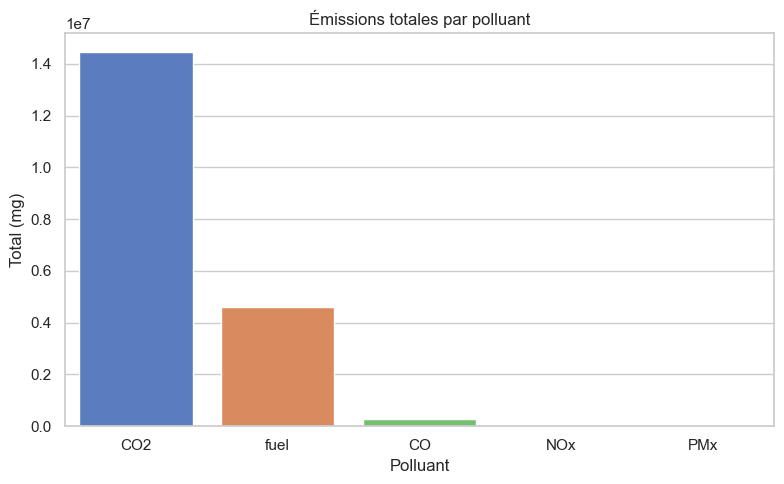

In [27]:
# 📊 Diagramme en barres des émissions totales
plt.figure(figsize=(8, 5))
total = df[polluants].sum().sort_values(ascending=False)
sns.barplot(x=total.index, y=total.values, hue=total.index, palette="muted", legend=False)
plt.title("Émissions totales par polluant")
plt.ylabel("Total (mg)")
plt.xlabel("Polluant")
plt.tight_layout()
plt.show()

C:\Users\Bakir\AppData\Local\Temp\ipykernel_14616\1158725032.py:10: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


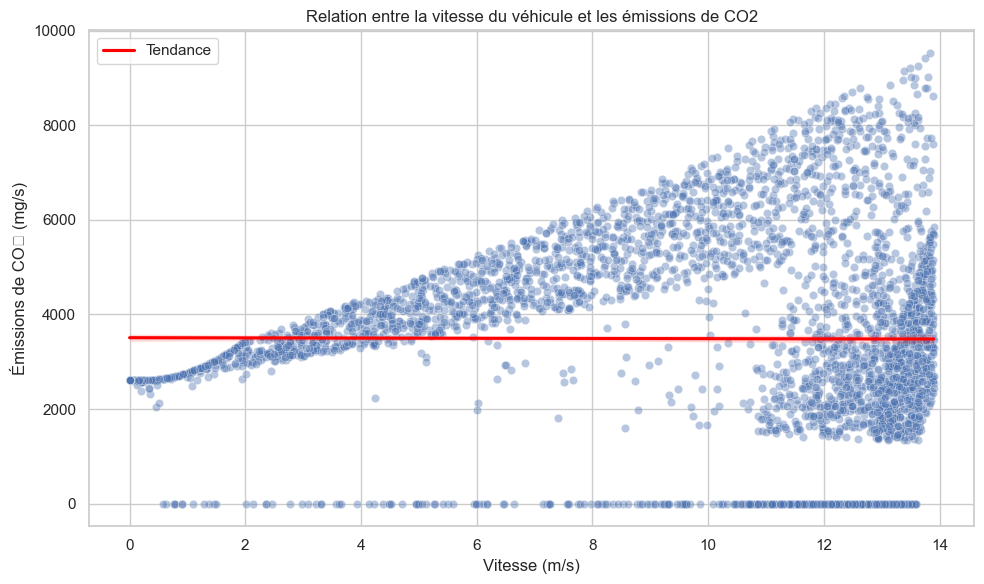

In [9]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="speed", y="CO2", alpha=0.4)
sns.regplot(data=df, x="speed", y="CO2", scatter=False, color='red', label="Tendance")

plt.title("Relation entre la vitesse du véhicule et les émissions de CO2")
plt.xlabel("Vitesse (m/s)")
plt.ylabel("Émissions de CO₂ (mg/s)")
plt.legend()
plt.tight_layout()
plt.show()

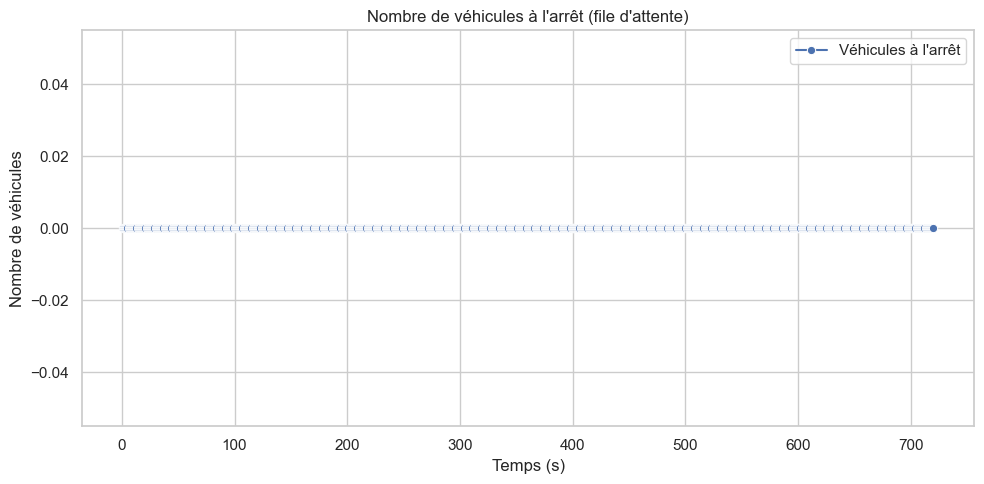

In [10]:

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q, x="time", y="haltingVehicles", marker="o", label="Véhicules à l'arrêt")
plt.title("Nombre de véhicules à l'arrêt (file d'attente)")
plt.xlabel("Temps (s)")
plt.ylabel("Nombre de véhicules")
plt.grid(True)
plt.tight_layout()
plt.show()



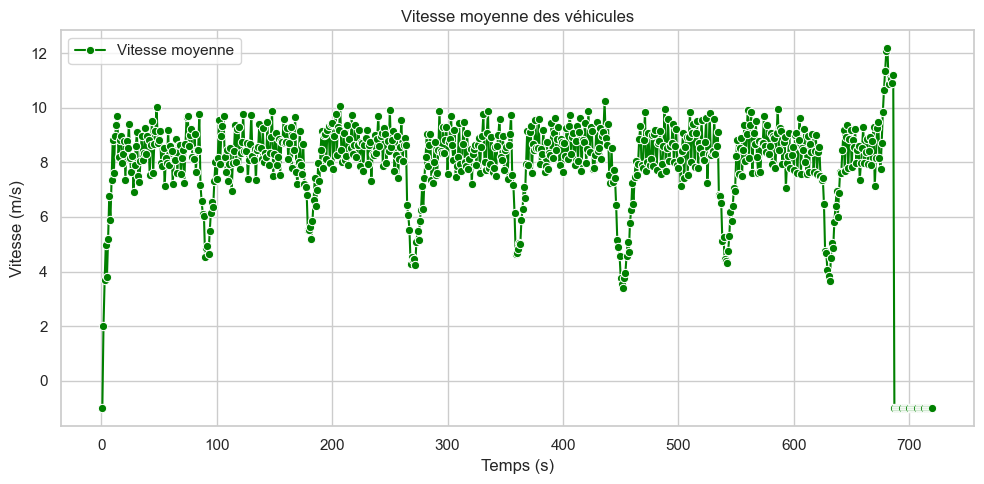

In [38]:

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q, x="time_end", y="meanSpeed", marker="o", color="green", label="Vitesse moyenne")
plt.title("Vitesse moyenne des véhicules")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

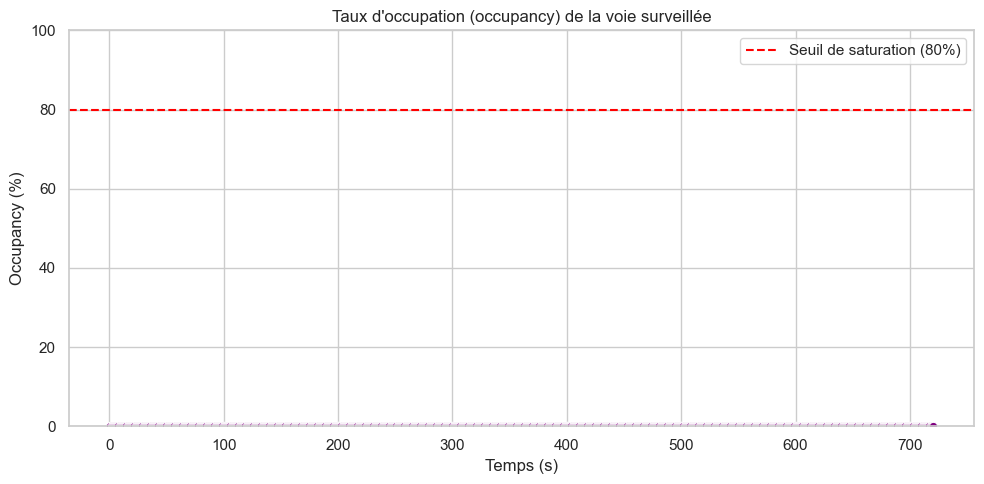

In [72]:

df_q["occupancy_percent"] = df_q["occupancy"] * 100


plt.figure(figsize=(10, 5))
sns.lineplot(data=df_q, x="time", y="occupancy_percent", marker="o", color="purple")
plt.title("Taux d'occupation (occupancy) de la voie surveillée")
plt.xlabel("Temps (s)")
plt.ylabel("Occupancy (%)")
plt.ylim(0, 100)
plt.axhline(80, color='red', linestyle='--', label='Seuil de saturation (80%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
poll_data = []
for timestep in root_p.findall("timestep"):
    time = float(timestep.attrib["time"])
    total_co2 = sum(float(v.attrib.get("CO2", 0)) for v in timestep.findall("vehicle"))
    poll_data.append({"time": time, "CO2": total_co2})

df_poll = pd.DataFrame(poll_data)

In [74]:
### 🔹 3. Fusionner les deux sur "time"
df_merged = pd.merge(df_q, df_poll, on="time", how="inner")

### 🔹 4. Corrélation et graphique
corr, _ = pearsonr(df_merged["haltingVehicles"], df_merged["CO2"])
print(f"🔗 Corrélation (Pearson) entre file d'attente et CO₂ : {corr:.3f}")

🔗 Corrélation (Pearson) entre file d'attente et CO₂ : nan


C:\Users\Bakir\AppData\Local\Temp\ipykernel_13100\1862822319.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_merged["haltingVehicles"], df_merged["CO2"])
